In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt

alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [5]:
nyc_df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-12-11/nyc_restaurants.csv")

In [6]:
nyc_df.shape

(300000, 13)

In [7]:
nyc_df['inspection_date'].str[-4:].value_counts()

2018    112606
2017     78047
2016     73750
2015     34339
1900       796
2014       453
2013         7
2012         2
Name: inspection_date, dtype: int64

In [8]:
nyc_df_drop_na = nyc_df[nyc_df['grade'].notna()]
nyc_df_drop_na['inspection_date'].str[-4:].value_counts()

2018    57857
2017    38895
2016    37846
2015    16647
2014      202
2012        2
2013        2
Name: inspection_date, dtype: int64

In [9]:
nyc_df_cleaned = nyc_df_drop_na.loc[nyc_df['grade'] != 'Not Yet Graded']
nyc_df_cleaned['grade'].value_counts()

A    119647
B     19215
C      5888
Z      3316
P      1819
Name: grade, dtype: int64

In [10]:
119647/149855

0.7984184711888158

In [11]:
nyc_df_cleaned.loc[nyc_df_cleaned['grade'] != 'A', 'grade'] = 'F'
nyc_df_cleaned['grade'].value_counts()

A    119647
F     30238
Name: grade, dtype: int64

In [12]:
train_df, test_df = train_test_split(nyc_df_cleaned, test_size=0.25, random_state=123)

In [13]:
train_df['grade'].value_counts()

A    89789
F    22624
Name: grade, dtype: int64

In [14]:
test_df['grade'].value_counts()

A    29858
F     7614
Name: grade, dtype: int64

In [15]:
score_hist = (
    alt.Chart(train_df).mark_bar(opacity=0.5).encode(
    alt.X('score', bin=True, scale=alt.Scale(domain=[0, 100]), title='Score'),
    alt.Y('count()'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'), title='Grade')
))

In [16]:
score_dens_plot = (
    alt.Chart(
    train_df
).transform_density(
    'score',
    groupby=['grade'],
    as_=['score', 'density'],
    extent=[0, 80],
).mark_area(opacity=0.4).encode(
    alt.X('score', title='Score'),
    alt.Y('density:Q', title='Density'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'), title='Grade')
))

In [17]:
score_dists = (score_hist | score_dens_plot).properties(title='Distribution of Scores by Grade')

In [24]:
score_dists.save('score_dists.html')

/Users/lzung/opt/miniconda3/envs/571/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


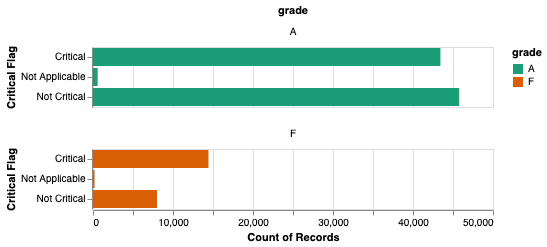

In [28]:
alt.Chart(train_df).mark_bar().encode(
    alt.X('count()'),
    alt.Y('critical_flag', title='Critical Flag'),
    alt.Color('grade', scale=alt.Scale(scheme='dark2'))
).facet('grade', columns=1)